In [2]:
import timm
import torch
import torch.nn as nn
import torch.optim as optim

In [3]:
class FewShotEfficientNet(nn.Module):
    def __init__(self, num_classes=10):
        super(FewShotEfficientNet, self).__init__()
        self.backbone = timm.create_model('efficientnet_b0', pretrained=True)  # Load pretrained EfficientNet-B0
        self.backbone.classifier = nn.Linear(self.backbone.classifier.in_features, num_classes)  # Replace last layer

    def forward(self, x):
        return self.backbone(x)

In [35]:
def train_few_shot_efficientnet(model, dataloader, epochs=10, lr=0.001):
    for param in model.backbone.blocks[0].parameters():
        param.requires_grad = False
    for param in model.backbone.blocks[1].parameters():
        param.requires_grad = False
    for param in model.backbone.blocks[2].parameters():
        param.requires_grad = False
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        
        for images, labels in dataloader:  # Load few-shot dataset
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    
            running_loss += loss.item()
    
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss:.4f}")

In [36]:
from src.few_shot_learning import load_cinic10, calculate_accuracy, plot_confusion_matrix
data_dir = "../../data"
dataloader = load_cinic10(data_dir, few_shot_per_class=100)
model = FewShotEfficientNet()
train_few_shot_efficientnet(model, dataloader, epochs=30)

Epoch [1/30], Loss: 136.8276
Epoch [2/30], Loss: 108.3174
Epoch [3/30], Loss: 98.8998
Epoch [4/30], Loss: 88.8381
Epoch [5/30], Loss: 82.1826
Epoch [6/30], Loss: 71.6336
Epoch [7/30], Loss: 66.8554
Epoch [8/30], Loss: 60.8225
Epoch [9/30], Loss: 49.4567
Epoch [10/30], Loss: 41.6585
Epoch [11/30], Loss: 41.3139
Epoch [12/30], Loss: 45.2925
Epoch [13/30], Loss: 46.8962
Epoch [14/30], Loss: 40.1180
Epoch [15/30], Loss: 40.4188
Epoch [16/30], Loss: 37.1343
Epoch [17/30], Loss: 33.8120
Epoch [18/30], Loss: 25.6516
Epoch [19/30], Loss: 26.8035
Epoch [20/30], Loss: 26.6473
Epoch [21/30], Loss: 32.8032
Epoch [22/30], Loss: 31.2424
Epoch [23/30], Loss: 25.9657
Epoch [24/30], Loss: 20.0306
Epoch [25/30], Loss: 20.5128
Epoch [26/30], Loss: 18.0365
Epoch [27/30], Loss: 21.3748
Epoch [28/30], Loss: 19.8048
Epoch [29/30], Loss: 21.6892
Epoch [30/30], Loss: 23.1135


In [37]:
train_accuracy = calculate_accuracy(model, data_dir, split='train')

Accuracy on train set: 44.68%


In [38]:
test_accuracy = calculate_accuracy(model, data_dir, split='test')

Accuracy on test set: 42.50%


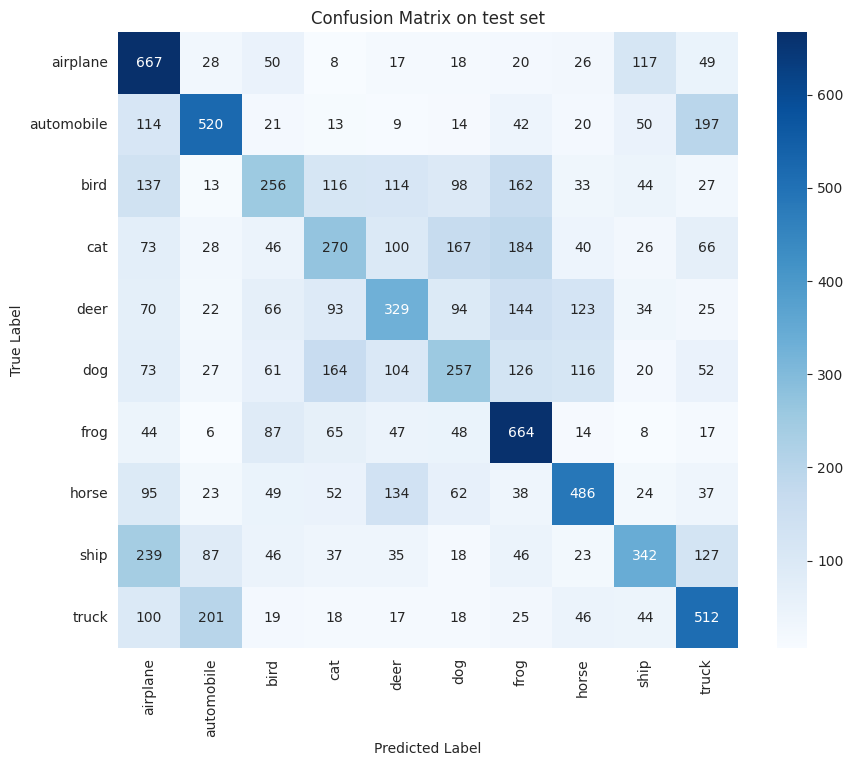

In [39]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']
plot_confusion_matrix(model, data_dir, split='test', class_names=class_names)